<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#!pip install finta
df = web.DataReader('3481.tw','yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(3166, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2006-10-24,50.110100,45.683701,47.604599,45.767200,9.928784e+07
2006-10-25,45.934200,42.092400,45.934200,43.846298,4.607697e+07
2006-10-26,42.889198,40.961601,42.166401,42.327000,2.724332e+10


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-04,7.05,6.93,6.94,7.04,58686252.0
2019-09-05,7.13,7.01,7.10,7.01,62700785.0
2019-09-06,7.19,7.01,7.05,7.16,116308137.0


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close, 1.07, 0.97, 20)['triple_barrier_signal']
df = df.join(ret)

In [6]:
df.head()

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2006-10-24,50.110100,45.683701,47.604599,45.767200,9.928784e+07,-1
2006-10-25,45.934200,42.092400,45.934200,43.846298,4.607697e+07,-1
2006-10-26,42.889198,40.961601,42.166401,42.327000,2.724332e+10,1
2006-10-27,45.099098,43.762798,45.099098,44.263901,3.003948e+07,1
2006-10-30,44.263901,43.428699,43.846298,43.428699,1.011054e+07,1


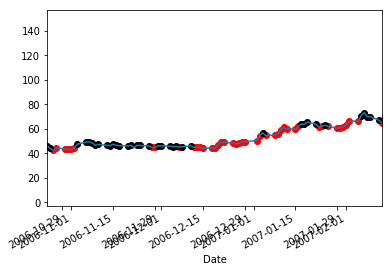

In [7]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][0:80].plot()
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    3165.000000
mean       48.835105
std        16.595292
min         0.000000
25%        37.480427
50%        48.824926
75%        60.155706
max        92.656815
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238


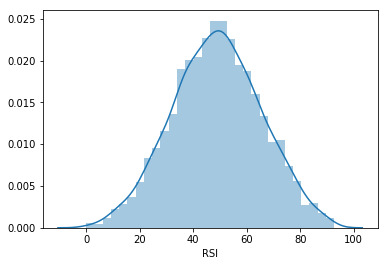

In [9]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    3153.000000
mean      -54.558401
std        30.536138
min      -100.000000
25%       -82.658359
50%       -56.250030
75%       -27.777486
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357


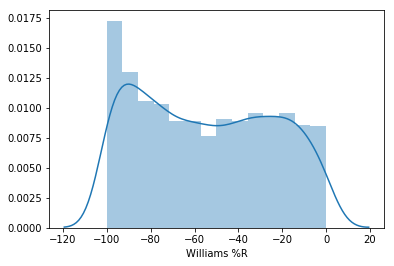

In [10]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count    3126.000000
mean       27.572607
std        26.335042
min         6.946585
25%        11.303643
50%        14.329268
75%        38.115670
max       129.534976
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585


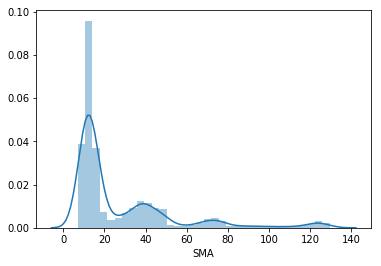

In [11]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count    3166.000000
mean       27.603003
std        26.431100
min         6.284750
25%        11.257825
50%        14.444027
75%        38.232830
max       137.159774
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516


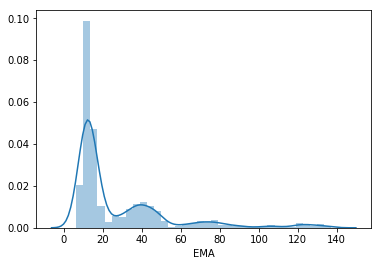

In [12]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count    3158.000000
mean       27.576093
std        26.484762
min         6.177333
25%        11.265833
50%        14.462778
75%        37.816841
max       140.988958
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556


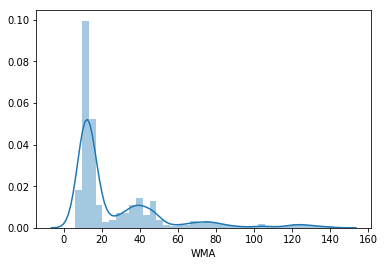

In [13]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count    3163.000000
mean       27.562834
std        26.501974
min         6.081000
25%        11.265285
50%        14.465960
75%        37.978680
max       142.446104
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998


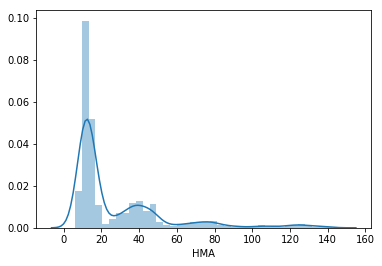

In [14]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count    3166.000000
mean       27.555336
std        26.526960
min         5.900177
25%        11.300303
50%        14.526711
75%        37.894501
max       145.363252
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726


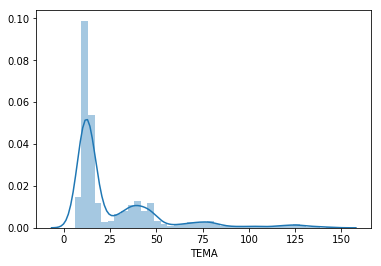

In [15]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    3165.000000
mean       -3.993339
std        88.706008
min      -238.091407
25%       -76.308956
50%        -6.742347
75%        65.395920
max       244.848855
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363


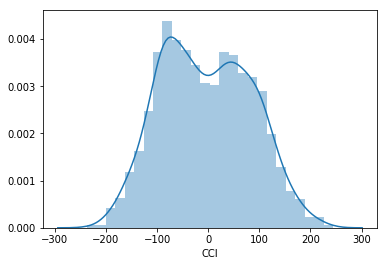

In [16]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    3157.000000
mean       -2.187673
std        41.373920
min      -100.000000
25%       -31.917840
50%        -1.681903
75%        28.282018
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345


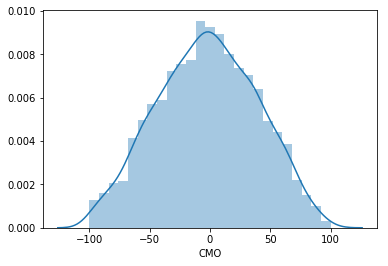

In [17]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    3166.000000
mean       -0.000047
std         0.441797
min        -3.544346
25%        -0.100148
50%         0.005438
75%         0.099083
max         3.210115
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916


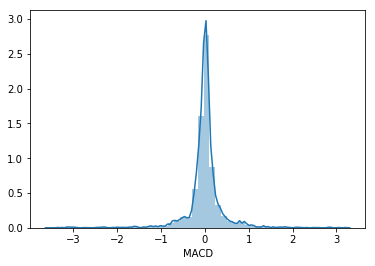

In [18]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    3166.000000
mean       -0.000683
std         0.981859
min        -2.990214
25%        -0.595348
50%         0.004953
75%         0.550465
max         5.325322
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618,1.122326
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566,1.048693
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134,1.071519
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030,1.010678
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916,1.065209


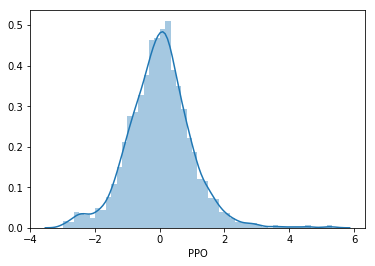

In [19]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    3154.000000
mean       -0.191874
std        10.128694
min       -40.706426
25%        -5.614744
50%        -0.479670
75%         5.273361
max        43.674733
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618,1.122326,16.778523
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566,1.048693,14.569538
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134,1.071519,7.810103
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030,1.010678,-0.426133
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916,1.065209,4.525547


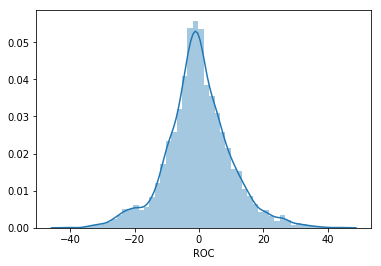

In [20]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    3.157000e+03
mean     6.025402e+09
std      1.220307e+10
min     -2.364300e+10
25%      9.224420e+09
50%      1.052695e+10
75%      1.248007e+10
max      1.562805e+10
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618,1.122326,16.778523,1.379451e+10
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566,1.048693,14.569538,1.380177e+10
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134,1.071519,7.810103,1.380899e+10
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030,1.010678,-0.426133,1.381456e+10
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916,1.065209,4.525547,1.382229e+10


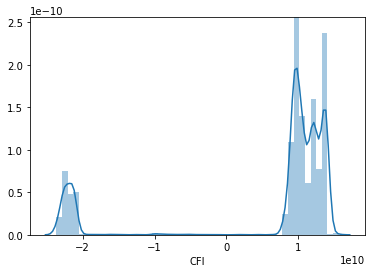

In [21]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    3083.000000
mean       -0.486316
std        23.758501
min      -120.015010
25%       -14.637867
50%        -1.125361
75%        12.102207
max       117.034017
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618,1.122326,16.778523,1.379451e+10,20.002075
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566,1.048693,14.569538,1.380177e+10,14.814031
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134,1.071519,7.810103,1.380899e+10,12.838827
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030,1.010678,-0.426133,1.381456e+10,16.197720
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916,1.065209,4.525547,1.382229e+10,17.854035


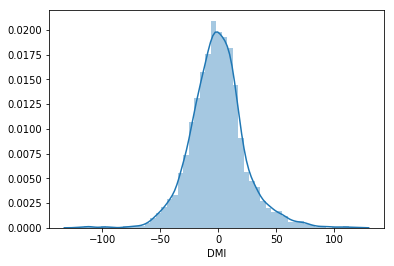

In [22]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count    3166.000000
mean       27.810216
std        26.918903
min         5.760000
25%        11.388084
50%        14.631072
75%        37.555543
max       154.606003
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,7.10,6.96,7.09,6.96,68714019.0,0,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618,1.122326,16.778523,1.379451e+10,20.002075,6.530971
2019-09-03,7.08,6.92,7.00,6.92,49562988.0,0,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566,1.048693,14.569538,1.380177e+10,14.814031,6.595693
2019-09-04,7.05,6.93,6.94,7.04,58686252.0,0,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134,1.071519,7.810103,1.380899e+10,12.838827,6.655238
2019-09-05,7.13,7.01,7.10,7.01,62700785.0,0,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030,1.010678,-0.426133,1.381456e+10,16.197720,6.710019
2019-09-06,7.19,7.01,7.05,7.16,116308137.0,0,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916,1.065209,4.525547,1.382229e+10,17.854035,6.760417


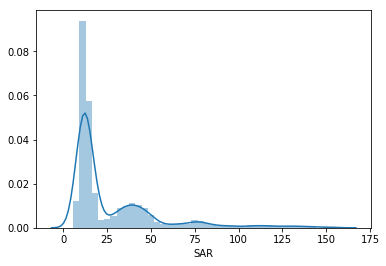

In [23]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [24]:
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #15個剛剛建立的技術指標
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(3083, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,57.991622,-24.050641,6.972195,6.816864,6.866000,6.795,6.980470,72.534912,-5.479447,0.076618,1.122326,16.778523,1.379451e+10,20.002075,6.530971,0
2019-09-03,56.002480,-26.582285,6.962439,6.837491,6.870000,6.898,6.982150,65.991933,5.343525,0.071566,1.048693,14.569538,1.380177e+10,14.814031,6.595693,0
2019-09-04,60.671992,-18.987355,6.954634,6.877993,6.827111,6.984,7.036660,65.686128,-3.333331,0.073134,1.071519,7.810103,1.380899e+10,12.838827,6.655238,0
2019-09-05,58.869723,-25.781240,6.947561,6.904395,6.833778,6.969,7.051855,65.971199,16.000040,0.069030,1.010678,-0.426133,1.381456e+10,16.197720,6.710019,0
2019-09-06,64.887238,-24.324357,6.946585,6.955516,6.829556,6.998,7.129726,70.624363,21.495345,0.072916,1.065209,4.525547,1.382229e+10,17.854035,6.760417,0


# 相關性分析

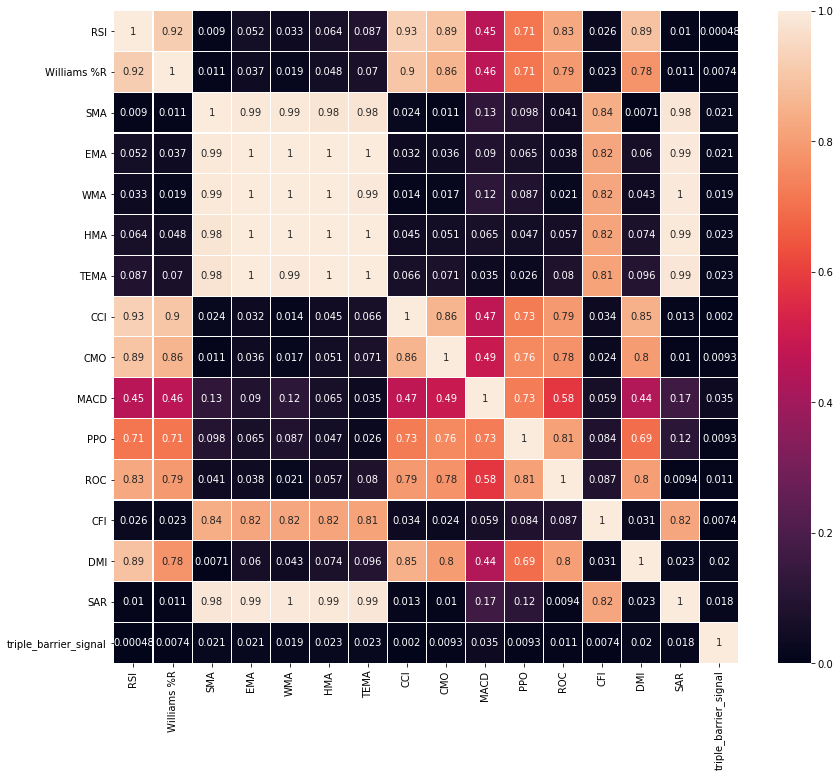

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index=df.index,
                         columns=df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
print(df_minmax.describe())
df_minmax.tail()

               RSI  Williams %R  ...          SAR  triple_barrier_signal
count  3083.000000  3083.000000  ...  3083.000000            3083.000000
mean      0.513766     0.450684  ...     0.143901              -0.301330
std       0.181956     0.305326  ...     0.181197               0.901197
min       0.000000     0.000000  ...     0.000000              -1.000000
25%       0.388981     0.166704  ...     0.037453              -1.000000
50%       0.514589     0.428573  ...     0.058422              -1.000000
75%       0.638845     0.718626  ...     0.201693               1.000000
max       1.000000     1.000000  ...     1.000000               1.000000

[8 rows x 16 columns]


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,0.617479,0.759494,0.000209,0.004066,0.005108,0.005236,0.007746,0.643198,0.472603,0.536085,0.494561,0.681253,0.952467,0.590667,0.005180,0
2019-09-03,0.595530,0.734177,0.000129,0.004223,0.005138,0.005991,0.007758,0.629650,0.526718,0.535337,0.485706,0.655075,0.952655,0.568781,0.005614,0
2019-09-04,0.647056,0.810126,0.000066,0.004533,0.004820,0.006622,0.008149,0.629017,0.483333,0.535569,0.488451,0.574969,0.952842,0.560449,0.006015,0
2019-09-05,0.627169,0.742188,0.000008,0.004735,0.004869,0.006512,0.008258,0.629607,0.580000,0.534961,0.481135,0.477361,0.952987,0.574618,0.006383,0
2019-09-06,0.693570,0.756756,0.000000,0.005125,0.004838,0.006725,0.008816,0.639242,0.607477,0.535537,0.487692,0.536044,0.953187,0.581606,0.006721,0


In [27]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [28]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

for i in tqdm(range(b_index,f_index,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 3068/3068 [00:06<00:00, 460.21it/s]


準備完成


# check

In [29]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 3068
第一筆的index開始和結束:2007-03-01-2007-03-22
最後一筆的index開始和結束:2019-08-15-2019-09-06


# Reshape X

(圖片數量,長,寬,1張)

In [30]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(3068, 15, 15)
(3068, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [31]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(3068, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]]


Using TensorFlow backend.


(3068, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

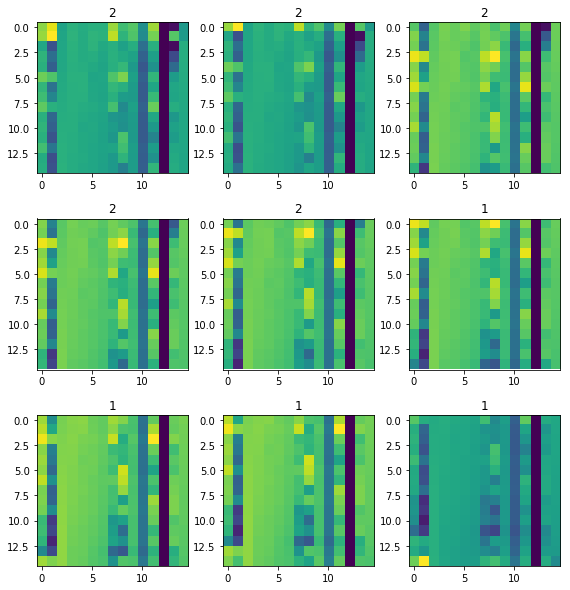

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [33]:
X_test = Xs[-2:] #最後兩筆features當作test
X_train,y_train = Xs[:-2],ys[:-2] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(3066, 15, 15, 1) (3066, 3) (2, 15, 15, 1)


In [34]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2,
                                              random_state=42,
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2452, 15, 15, 1) (2452, 3) (614, 15, 15, 1) (614, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [35]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

2    1843
1     926
0     299
dtype: int64

In [36]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

2    1480
1     736
0     236
dtype: int64

In [37]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

2    363
1    190
0     61
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [39]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(nclasses, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    


In [40]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_loss',#驗證集loss
                   min_delta=0, 
                   patience=20,  
                   mode='min',
                   restore_best_weights=False)#恢復最佳權重

# fit

In [42]:
history = model.fit(xtrain,ytrain,
                    batch_size=128,
                    epochs=200,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2452 samples, validate on 614 samples
Epoch 1/200
2452/2452 [==============================] - 3s 1ms/step - loss: 0.9249 - acc: 0.5750 - val_loss: 0.8942 - val_acc: 0.5912
Epoch 2/200
2452/2452 [==============================] - 0s 58us/step - loss: 0.8894 - acc: 0.6044 - val_loss: 0.8906 - val_acc: 0.5912
Epoch 3/200
2452/2452 [==============================] - 0s 55us/step - loss: 0.8856 - acc: 0.6044 - val_loss: 0.8824 - val_acc: 0.5912
Epoch 4/200
2452/2452 [==============================] - 0s 53us/step - loss: 0.8746 - acc: 0.5999 - val_loss: 0.8783 - val_acc: 0.5912
Epoch 5/200
2452/2452 [==============================] - 0s 50us/step - loss: 0.8770 - acc: 0.6024 - val_loss: 0.8811 - val_acc: 0.5912
Epoch 6/200
2452/2452 [==============================] - 0s 49us/step - loss: 0.8709 - acc: 0.6036 - val_loss: 0.8780 - val_acc: 0.5912
Epoch 7/200
2452/2452 [=====================

# 訓練過程評估

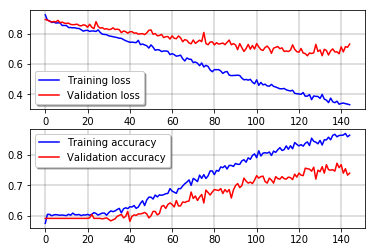

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

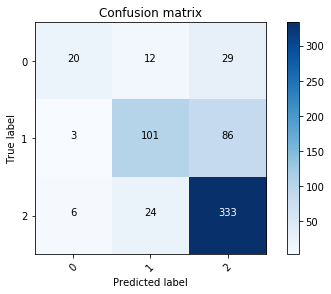

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [45]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


真實y值

In [46]:
print(yval[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


# 分類報告

In [47]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.69      0.33      0.44        61
         BUY       0.74      0.53      0.62       190
        SELL       0.74      0.92      0.82       363

   micro avg       0.74      0.74      0.74       614
   macro avg       0.72      0.59      0.63       614
weighted avg       0.74      0.74      0.72       614
 samples avg       0.74      0.74      0.74       614



# plot error

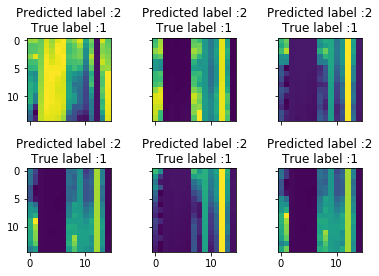

In [48]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

# predict!

In [49]:
answer = model.predict(X_test)
answer

array([[8.3176070e-01, 3.0339180e-04, 1.6793582e-01],
       [5.4272622e-01, 8.3506759e-03, 4.4892302e-01]], dtype=float32)

# 0:HOLD 1:BUY 2:SELL

In [50]:
answer = [ np.argmax(i) for i in answer]
answer

[0, 0]